In [42]:
import pandas as pd
# 超参数
COLS_LOTTERY_NUMBER_1 = '号码1'
COLS_LOTTERY_NUMBER_2 = '号码2'
COLS_LOTTERY_NUMBER_3 = '号码3'
COLS_INDEX = '期号'
COLS_ALL = [COLS_INDEX, COLS_LOTTERY_NUMBER_1, COLS_LOTTERY_NUMBER_2, COLS_LOTTERY_NUMBER_3, '跨度','和值']

# 读取excel文件并获取指定列dataframe
df = pd.read_excel('../Data/福彩3D历史开奖.xlsx', usecols=COLS_ALL)
df = df[:500]
print(df)

          期号  号码1  号码2  号码3  跨度  和值
0    2024270    6    9    9   3  24
1    2024269    3    8    8   5  19
2    2024268    9    3    1   8  13
3    2024267    2    2    7   5  11
4    2024266    3    9    0   9  12
..       ...  ...  ...  ...  ..  ..
495  2023126    4    9    6   5  19
496  2023125    0    0    7   7   7
497  2023124    2    3    6   4  11
498  2023123    8    0    4   8  12
499  2023122    4    1    2   3   7

[500 rows x 6 columns]


In [43]:
### 添加所需要的列 ###
import utils
cols_lottery = [COLS_LOTTERY_NUMBER_1, COLS_LOTTERY_NUMBER_2, COLS_LOTTERY_NUMBER_3]

# 特征列：本期是否有某数字
df['本期是否有0'] = utils.check_number_in_lottery(df, cols_lottery, 0)
df['本期是否有1'] = utils.check_number_in_lottery(df, cols_lottery, 1)
df['本期是否有2'] = utils.check_number_in_lottery(df, cols_lottery, 2)
df['本期是否有3'] = utils.check_number_in_lottery(df, cols_lottery, 3)
df['本期是否有4'] = utils.check_number_in_lottery(df, cols_lottery, 4)
df['本期是否有5'] = utils.check_number_in_lottery(df, cols_lottery, 5)
df['本期是否有6'] = utils.check_number_in_lottery(df, cols_lottery, 6)
df['本期是否有7'] = utils.check_number_in_lottery(df, cols_lottery, 7)
df['本期是否有8'] = utils.check_number_in_lottery(df, cols_lottery, 8)
df['本期是否有9'] = utils.check_number_in_lottery(df, cols_lottery, 9)

# 特征列：奇偶
df['和值为偶数'] = utils.check_even_number(df, '和值')
df['跨度为偶数'] = utils.check_even_number(df, '跨度')
df['号码1为偶数'] = utils.check_even_number(df, COLS_LOTTERY_NUMBER_1)
df['号码2为偶数'] = utils.check_even_number(df, COLS_LOTTERY_NUMBER_2)
df['号码3为偶数'] = utils.check_even_number(df, COLS_LOTTERY_NUMBER_3)
df['本期全为偶数'] = utils.check_all_even_numbers(df, cols_lottery)
df['本期全为奇数'] = utils.check_all_odd_numbers(df, cols_lottery)

# 特征列：形态
df['是组六'] = utils.check_no_same(df, cols_lottery)
df['是组三'] = utils.check_two_same(df, cols_lottery)
df['是豹子'] = utils.check_three_same(df, cols_lottery)


# 预测列
# df['下期是否全为偶数'] = utils.predict_all_even_numbers(df, cols_lottery)
# df['下期百位是否有2'] = utils.check_number_in_next_column(df, COLS_LOTTERY_NUMBER_1, 3)

# 预测列：形态
df['下期是组六'] = utils.predict_no_same(df, cols_lottery)
# df['下期是组三'] = utils.predict_two_same(df, cols_lottery)
# df['下期是豹子'] = utils.predict_three_same(df, cols_lottery)

df = df.drop(df.index[0])    # 从df中删除第一行，因为这一行没办法确认下一期是否有指定数字
print(df.head(5))

# 定义好预测列
COLS_Y = '下期是组六'
COLS_Y_CLASSNAME = ["不是组六", "是组六"]
CLASS_WEIGHTS = {0: 1, 1: 1}

        期号  号码1  号码2  号码3  跨度  和值  本期是否有0  本期是否有1  本期是否有2  本期是否有3  ...  跨度为偶数  \
1  2024269    3    8    8   5  19   False   False   False    True  ...  False   
2  2024268    9    3    1   8  13   False    True   False    True  ...   True   
3  2024267    2    2    7   5  11   False   False    True   False  ...  False   
4  2024266    3    9    0   9  12    True   False   False    True  ...  False   
5  2024265    2    4    5   3  11   False   False    True   False  ...  False   

   号码1为偶数  号码2为偶数  号码3为偶数  本期全为偶数  本期全为奇数    是组六    是组三    是豹子  下期是组六  
1   False    True    True   False   False  False   True  False  False  
2   False   False   False   False    True   True  False  False  False  
3    True    True   False   False   False  False   True  False   True  
4   False   False    True   False   False   True  False  False  False  
5    True    True   False   False   False   True  False  False   True  

[5 rows x 27 columns]


In [44]:
from sklearn.model_selection import train_test_split

## 取需要训练的值
cols_x = df.drop(columns=[COLS_Y,COLS_INDEX])
cols_y = df[COLS_Y]
# print(cols_x)
# print(cols_y)
cols_x_names = cols_x.columns.tolist()

Xtrain, Xtest, Ytrain, ytest = train_test_split(cols_x, cols_y, test_size = 0.002, random_state=102) 

print(Xtrain.shape)
print(Xtest.shape)

(498, 25)
(1, 25)


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 训练模型
clf = RandomForestClassifier(n_estimators=5000,  
                             max_depth = 3, 
                             criterion='entropy',
                             min_samples_leaf=5, 
                             max_features = 3,
                             class_weight=CLASS_WEIGHTS,
                             bootstrap=False,   # 特别核心，所有决策树都用全部数据做训练
                             random_state = 13)  #最大{max_depth}层，最少也需要{lefa}个样本才生成分支
clf = clf.fit(Xtrain, Ytrain) 

# 预测测试集
y_pred = clf.predict(Xtest)

# 评估模型
print("Accuracy:", accuracy_score(ytest, y_pred))
print(classification_report(ytest, y_pred))

#print('精准度： '+str(clf.score(Xtest, ytest))) #返回预测的准确度
#print([*zip(feature_name,clf.feature_importances_)]) #返回决策树各自变量的重要程度

Accuracy: 1.0
              precision    recall  f1-score   support

        True       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [46]:
### STEP：找到路径

# 寻找父节点， 被get_path调用
def get_parent_node_id(tree_, node_id, feature_names):
    # 遍历所有的节点，找到node_id的父节点
    for i in range(tree_.node_count):
        # 如果左子节点/或右子节点是node_id，则父节点是当前节点
        if tree_.children_left[i] == node_id or tree_.children_right[i] == node_id:
            parent_node_id = i
            
            # 获取父节点的特征名称和阈值
            feature_index = tree_.feature[i]
            threshold = tree_.threshold[i]

            # 分别处理父节点的左节点是node_id/右节点是node_id的情况
            if tree_.children_left[i] == node_id:
                # print(f"{feature_names[feature_index]} <= {threshold}")
                rule = (feature_names[feature_index], '<=', threshold)
            elif tree_.children_right[i] == node_id:
                # print(f"{feature_names[feature_index]} > {threshold}")
                rule = (feature_names[feature_index], '>', threshold)
            return parent_node_id, rule
        
    # 如果没有找到父节点，返回None和None
    return None, None

# 顺着路径找公式
def get_path(tree_, node_id, feature_names, depth=0, rules=None, rules_feature_set=None):
    # 准备记录rules，和rules用到的feature
    if rules is None:
        rules = []
    if rules_feature_set is None:
        rules_feature_set = set()

    # 递归函数，获取父节点ID和对应的规则，并依次向上寻找
    parent_node_id, rule = get_parent_node_id(tree_, node_id, feature_names)

    # 如果找到了规则，则将其添加到列表中
    if rule:
        rules.append(rule)
        rules_feature_set.add(rule[0]) 
    
    # 输出Rules
    if parent_node_id is None:
        print(f"总深度：{depth}")
        print(f"用到的总特征：{len(rules_feature_set)}")
        # for r in reversed(rules):   # 反转列表，使其从根节点到叶节点
        #     print(f"{r[0]} {r[1]} {r[2]}")
        print("-----Rules------")
        print(f"rules: {rules}")
        return rules
    else:
        return get_path(tree_, parent_node_id, feature_names, depth + 1, rules, rules_feature_set)


### 测试代码 ###

# 选择森林中的一棵树进行绘制
tree_num = 5        
print(clf.classes_)
tree_ = clf.estimators_[tree_num].tree_

# 找到基尼系数为零的节点
zero_gini_nodes = []
for i in range(tree_.node_count):
    if tree_.impurity[i] == 0:
        zero_gini_nodes.append(i)
print("基尼系数为零的节点索引：", zero_gini_nodes)

# 顺着决策路径，找公式
rules = get_path(tree_, zero_gini_nodes[0], cols_x_names)

[False  True]
基尼系数为零的节点索引： [14]
总深度：3
用到的总特征：3
-----Rules------
rules: [('号码1', '>', 5.5), ('号码3为偶数', '>', 0.5), ('本期是否有5', '>', 0.5)]


In [47]:
def apply_rules(df, rules):
    # 初始化掩码为True，意味着所有行最初都是符合条件的
    mask = pd.Series([True] * len(df), index=df.index)
    
    # 遍历规则列表
    for feature, op, value in rules:
        # 根据操作符生成相应的布尔掩码
        if op == '<':
            temp_mask = df[feature] < value
        elif op == '>':
            temp_mask = df[feature] > value
        elif op == '<=':
            temp_mask = df[feature] <= value
        elif op == '>=':
            temp_mask = df[feature] >= value
        elif op == '==':
            temp_mask = df[feature] == value
        else:
            raise ValueError(f"Unsupported operator: {op}")
        
        # 将当前规则的掩码与之前的掩码进行逻辑与操作
        mask = mask & temp_mask
    
    # 应用掩码并打印符合条件的行的特定列
    # print(f"mask: {mask}")
    print("-----该rules可验证期号-----")
    print(df.loc[mask]['期号'])

### 测试代码 ###
rules = get_path(tree_, zero_gini_nodes[0], cols_x_names)
apply_rules(df, rules)

总深度：3
用到的总特征：3
-----Rules------
rules: [('号码1', '>', 5.5), ('号码3为偶数', '>', 0.5), ('本期是否有5', '>', 0.5)]
-----该rules可验证期号-----
82     2024188
102    2024168
125    2024145
138    2024132
211    2024059
236    2024034
300    2023321
311    2023310
422    2023199
463    2023158
Name: 期号, dtype: int64


In [49]:
### 找到那些值得关注的树

# 找出来所有符合要求的树
def check_forest(clf):
    for i, tree in enumerate(clf.estimators_):
        tree_ = tree.tree_
        
        for j in range(tree_.node_count):
            # 获取节点的熵值
            node_entropy = tree_.impurity[j]
            
            # 获取节点的value（类别的统计信息）
            node_value = tree_.value[j]

            # 只关注第二个类别标签（对应于 'true'）
            true_class_value = node_value[0][1] if node_value.size > 1 else 0

            # 类别集中度【可修改为 0.8 即 80% 为第二个类别】
            if true_class_value == 1:  
                print(f"Tree {i} has 100% [{clf.classes_[1]}] leaf.")   # 输出类别标签（重点看是不是要关注第2个，例如false|true，我们node_value[0][1]取的是全是true的节点）

                # 对于有符合要求的节点的树，找到其路径
                zero_gini_nodes = []
                for i in range(tree_.node_count):
                    if tree_.impurity[i] == 0:
                        print("基尼系数为零的节点索引：", zero_gini_nodes)
                        zero_gini_nodes.append(i)

### 测试代码 ###
check_forest(clf)
# 选择森林中的一棵树进行绘制
# tree_num = 5         # 选择第n棵树

# tree_ = clf.estimators_[tree_num].tree_
# 找到基尼系数为零的节点


# 打印基尼系数为零的节点


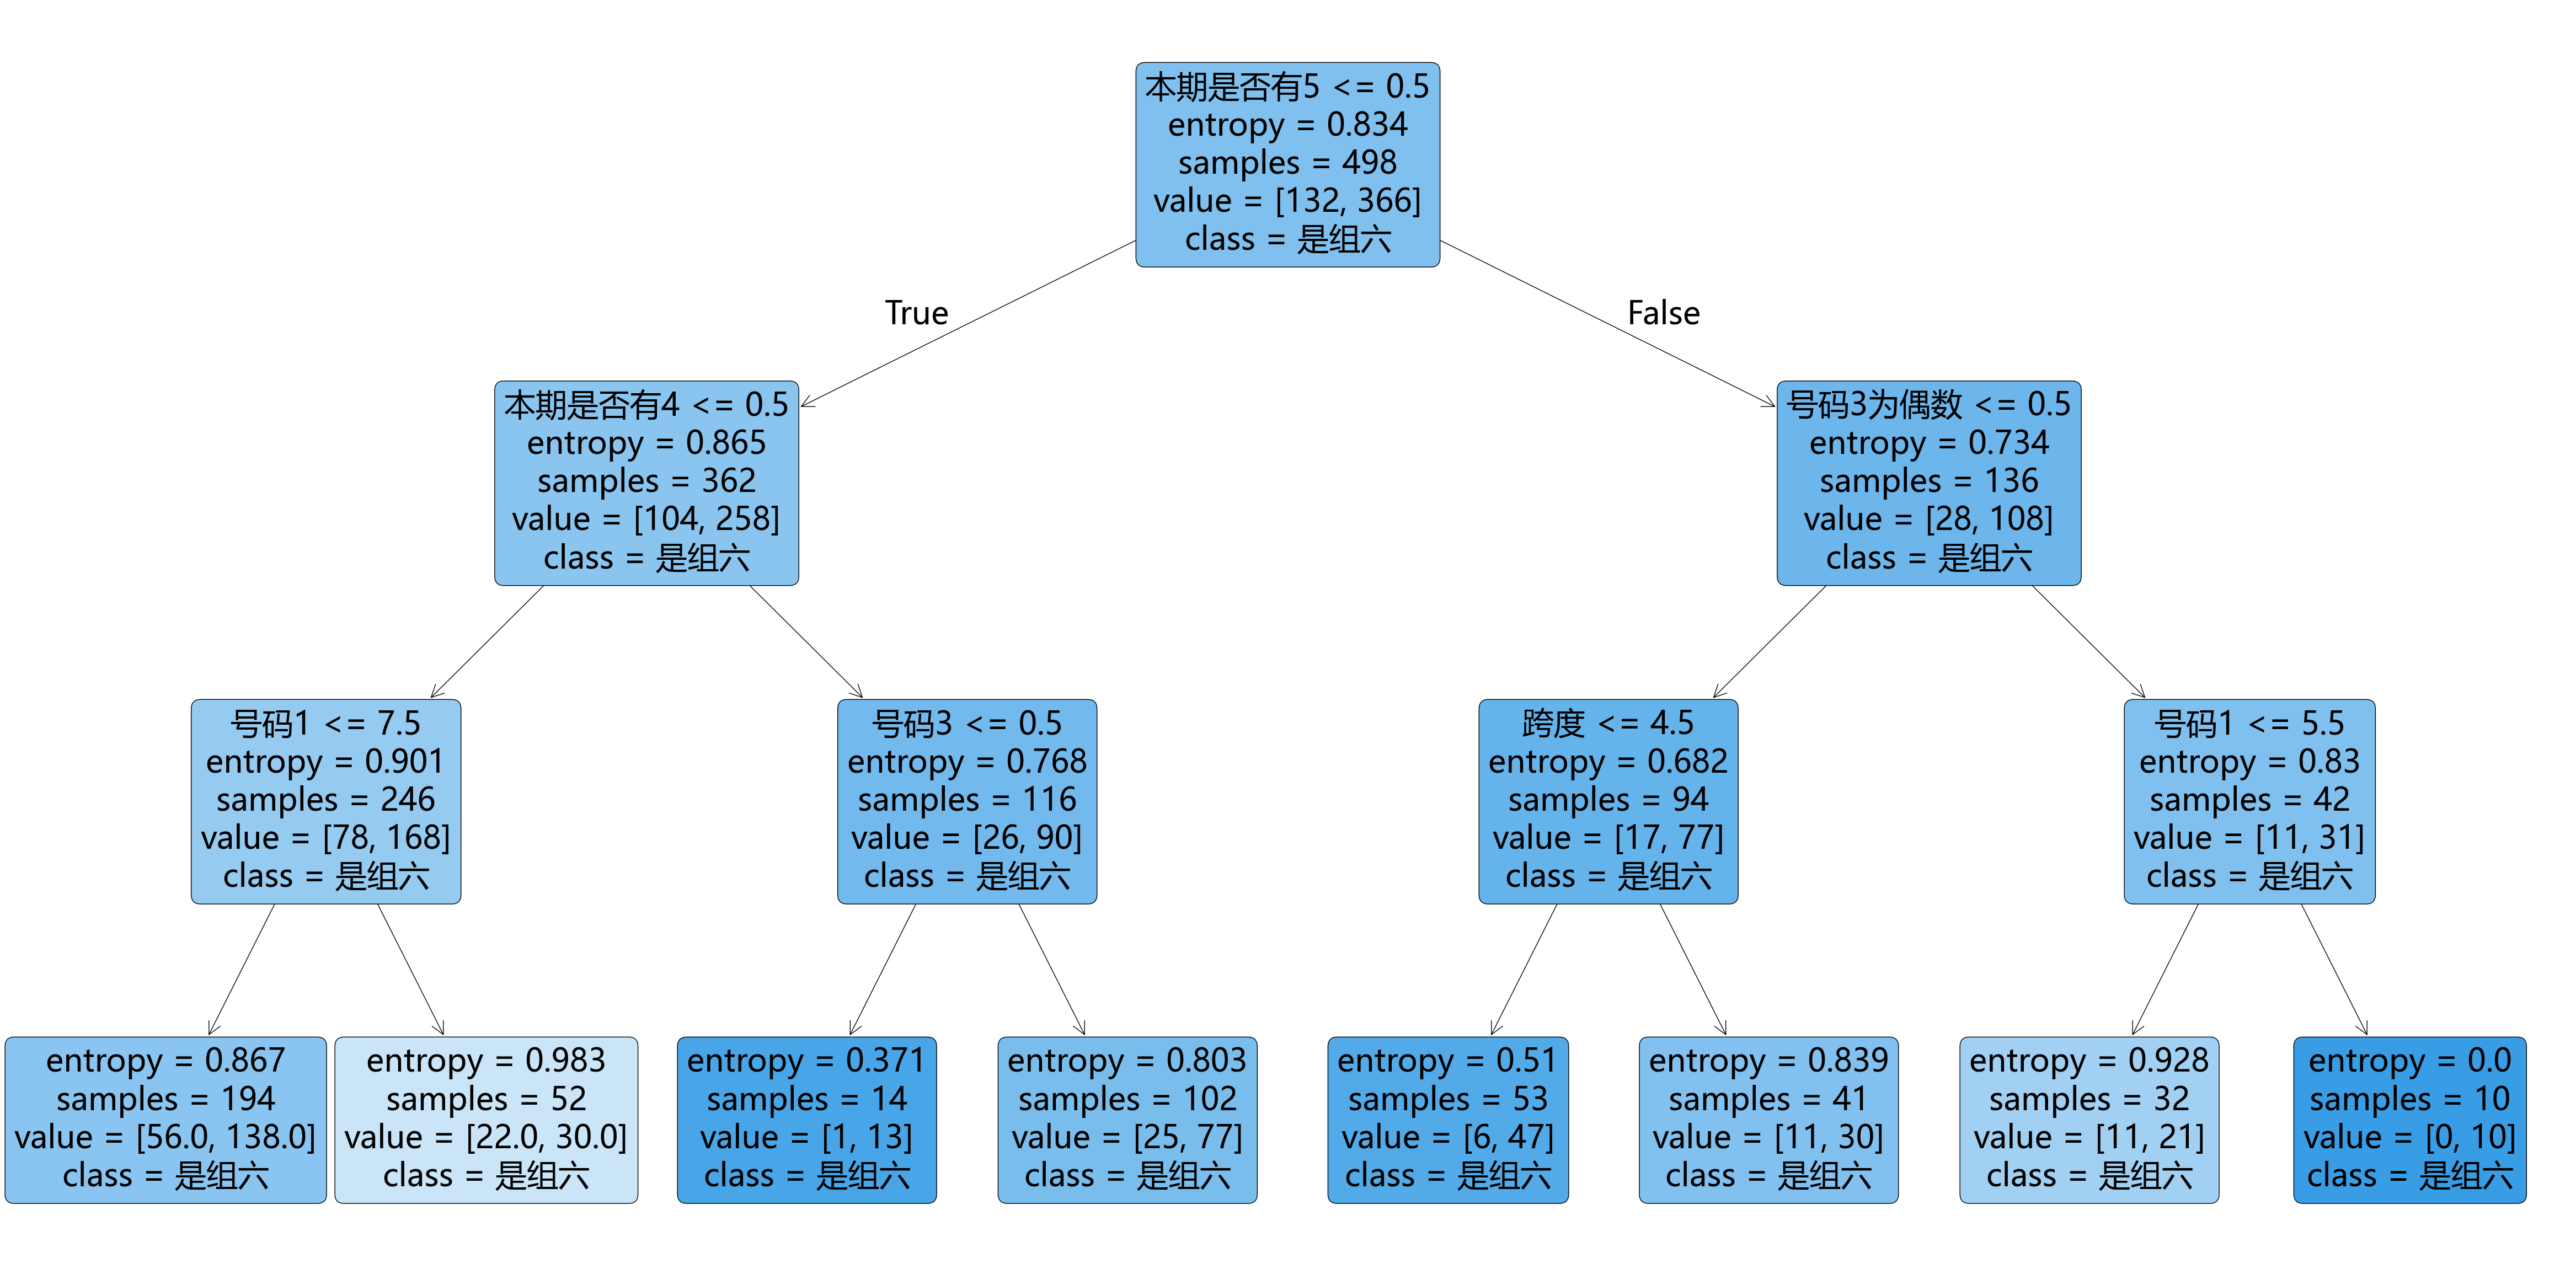

In [48]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 更好的中文字体，可以显示“-”号
plt.figure(figsize=(60,30))

plot_tree(clf.estimators_[tree_num], 
          feature_names=cols_x_names,
          class_names=COLS_Y_CLASSNAME, 
          filled=True, 
          rounded=True)
plt.show()